# Neural calssification module experiments
This notebook shows the experiments and training performed to test and use a Neural classification module as part of a Telesales System application, using an ASR post-correction module comprised of a phonetic correction algorithm and a Neural classifier. The results shown in the notebook were obtained using the real data of a large bottling company in Mexico. Unfortunately, we cannot share the original data due to the confidentiality agreement; however, we provide an anonymized version of the real data, which can be used to train the Neural Classification module.

## Import libraries
Tensorflow 2.0 and keras API were used to perform the experiments

In [61]:
import sys, os, re, csv, codecs, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import pandas as pd, numpy as np
import pickle
import datetime

## Main classes
A class **Histories** is implemented to save the training and validation loss and accuracy after each training batch and epoch. The class **SimpleModel** generates features using a word tokenizer trained on the data to get the index of the words. It also contains methods to get the general model, change the hyperparameters to test different network architectures, and to train, evaluate, and visualize model performance. Finally, the class **ModelROC** plots the AUC metric of the trained model.

In [91]:
class Histories(Callback):

    def on_train_begin(self,logs={}):
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_accuracies.append(logs.get('val_accuracy'))
        
class SimpleModel():
    
    def __init__(self, dropout_rate=0.5, maxlen=199, max_features=20000, embed_size=128):
        self.dropout_rate = dropout_rate
        self.maxlen = maxlen
        self.max_features = max_features
        self.embed_size = embed_size
        self.histories = Histories()
        self.model = self.createModel()
        
    def generateFeatures(self, data, test_size=0.00001, generate_tokenizer = True):
        
        if generate_tokenizer:
            return SimpleModel.getFeatures(data, test_size, None, self.maxlen)
        else:
            return SimpleModel.getFeatures(data, test_size, self.tokenizer, self.maxlen)
        
    def getFeatures(data, test_size = 0.2, tokenizer = None, maxlen=199):
        #Texts generation
        texts_to_correct = list(data.Text_to_correct)
        texts_corrected = list(data.Correction)
        texts = ["__startphrase__ " + a + " __endphrase__ " + "__startphrase__ " + b + " __endphrase__" for a,b in zip(texts_to_correct, texts_corrected)]
        print(len(texts_to_correct), len(texts_corrected))
        
        #Tokenizer generation
        if tokenizer is None:
            tokenizer = Tokenizer(num_words=20000)
            tokenizer.fit_on_texts(texts)
        
        #Feature generation
        list_classes = ["Correct"]
        y = data[list_classes].values
        list_tokenized_train = tokenizer.texts_to_sequences(texts)
        X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
        X_t = np.hstack((X_t, data.Phoco_thresh.values.reshape(X_t.shape[0], 1)))
        X_train, X_test, Y_train, Y_test = train_test_split(X_t, y, test_size = test_size)
        print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
        return X_train, X_test, Y_train, Y_test, tokenizer
    
    def createModel(self, dropout_rate = 0.5, maxlen=199, max_features=20000):
        inp = Input(shape=(self.maxlen + 1, )) #maxlen=200 as defined earlier
        x = Embedding(max_features, self.embed_size)(inp)
        x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
        x = GlobalMaxPool1D()(x)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(50, activation="relu")(x)
        x = Dropout(dropout_rate)(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        return model
    
    def train(self, epochs=2, batch_size=64):
        self.model.fit(self.X_train, self.Y_train, batch_size=batch_size, epochs=epochs, validation_data=(self.X_test, self.Y_test), callbacks=[self.histories])
        
    def evaluate(self, X, Y):
        self.model.evaluate(X, Y)
        predictions = self.model.predict(X)
        binarized = [0 if p < 0.5 else 1 for p in predictions]
        print(classification_report(Y, binarized))
    
    def save(self, filename = None):
        if not filename:
            generation_time = datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S')
        model_file_name = "model_" + generation_time + ".h5"
        self.model.save_weights(model_file_name)
        print("Saved model to disk: " + model_file_name)
        tokenizer_file = "tokenizer_" + generation_time + ".pickle"
        file = open(tokenizer_file, 'wb')
        pickle.dump(self.tokenizer, file)
        file.close()
        print("Saved tokenizer to disk: " + tokenizer_file)
    
    def plot(self):
        history = model.history
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        # Get number of epochs\n",
        epochs = range(len(acc))
        
        # Plot training and validation accuracy per epoch\n",
        plt.plot(epochs, acc)
        plt.plot(epochs, val_acc)
        plt.title('Training and validation accuracy')
        plt.figure()
        
        # Plot training and validation loss per epoch\n",
        plt.plot(epochs, loss)
        plt.plot(epochs, val_loss)
        plt.title('Training and validation loss')
        
    def plot2(self):
        #Get the number of processed batches
        epochs = range(len(self.histories.val_losses))
        batches = range(len(self.histories.losses))
        
        # Plot training and validation accuracy per epoch\n",
        plt.plot(batches, self.histories.losses)
        #plt.plot(epochs, self.histories.val_losses)
        #plt.plot(epochs, val_acc)
        plt.title('Training loss')
        plt.figure()
        
        # Plot training and validation loss per epoch\n",
        plt.plot(batches, self.histories.accuracies)
        #plt.plot(epochs, self.histories.val_accuracies)
        #plt.plot(epochs, val_loss)
        plt.title('Training accuracy')
        plt.show()
        
class ModelROC:
    def __init__(self, model, X_test, y_test, legend = 'model'):
        self.model = model
        y_pred = self.getPredictions(X_test)
        fpr, tpr, treshold = roc_curve(y_test, y_pred)
        self.fpr = fpr
        self.tpr = tpr
        self.treshold = treshold
        self.auc = auc(fpr, tpr)
        self.legend = legend
        print("Area under the curve " + self.legend + " " + str(self.auc))
    
    def getPredictions(self, X_test):
        return self.model.predict(X_test)
    
    def plotData(self):
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr, self.tpr, label= self.legend + ' (area = {:.3f})'.format(self.auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        
    def plot(self):
        plt.figure(1)
        self.plotData()
        plt.show()
        
    def zoom(self, zoom_x, zoom_y):
        plt.figure(2)
        plt.xlim(zoom_x[0], zoom_x[1])
        plt.ylim(zoom_y[0], zoom_y[1])
        self.plotData()
        plt.show()

## Helper functions
This functions are used to automate the training and evaluation process on the data

In [92]:
def trainModel(model):
    trainfile = './db/db_train.csv'
    train = pd.read_csv(trainfile)
    valfile = './db/db_val.csv'
    val = pd.read_csv(valfile)
    model.X_train, _, model.Y_train, _, model.tokenizer = model.generateFeatures(train)
    model.X_test, _, model.Y_test, _, _ = model.generateFeatures(train, 0.00001, False)
    model.train()
    model.plot2()
    model.evaluate(model.X_test, model.Y_test)
    mr = ModelROC(model.model, model.X_test, model.Y_test, legend="Neural corrector")
    mr.plot()
    return model

def evaluateModel(model, file):
    data = pd.read_csv(file)
    model.X_test, _, model.Y_test, _, _ = model.generateFeatures(data, test_size = 0.0001, generate_tokenizer = False)
    model.evaluate(model.X_test, model.Y_test)
    mr = ModelROC(model.model, model.X_train, model.Y_train, legend="Neural corrector")
    mr.plot()
    
def validateModel(model):
    evaluateModel(model,'./db/db_val.csv')
    
def testModel(model):
    evaluateModel(model,'./db/db_test.csv')

## Iterate over the models

18856 18856
Number of unique words: 275
(15084, 200) (15084, 1) (3772, 200) (3772, 1)
Epoch 1/2
213/213 [==============================] - 6s 27ms/step - loss: 0.4320 - accuracy: 0.8004 - val_loss: 0.2045 - val_accuracy: 0.9331
Epoch 2/2
213/213 [==============================] - 5s 26ms/step - loss: 0.1887 - accuracy: 0.9365 - val_loss: 0.1368 - val_accuracy: 0.9503


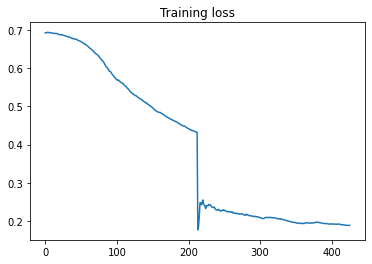

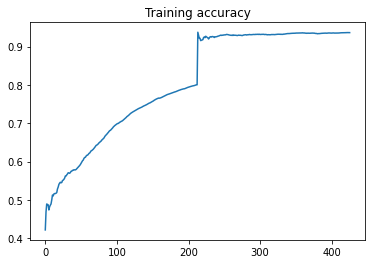

118/118 [==============================] - 1s 5ms/step - loss: 0.1159 - accuracy: 0.9578
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1675
           1       0.95      0.97      0.96      2097

    accuracy                           0.96      3772
   macro avg       0.96      0.96      0.96      3772
weighted avg       0.96      0.96      0.96      3772

Area under the curve Neural corrector 0.9909844198179346


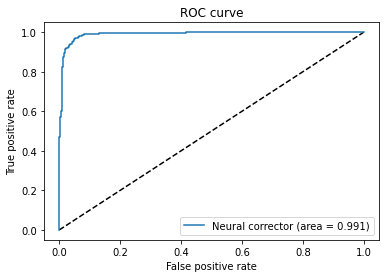

In [25]:
sm = trainModel(SimpleModel())

2357 2357
Number of unique words: 266
(2356, 200) (2356, 1) (1, 200) (1, 1)
74/74 [==============================] - 0s 5ms/step - loss: 0.1251 - accuracy: 0.9554
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1077
           1       0.94      0.97      0.96      1279

    accuracy                           0.96      2356
   macro avg       0.96      0.95      0.95      2356
weighted avg       0.96      0.96      0.96      2356

Area under the curve Neural corrector 0.990776655682865


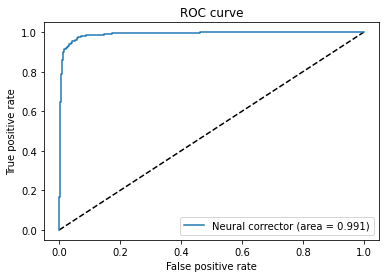

In [26]:
validateModel(sm)

2358 2358
Number of unique words: 265
(2357, 200) (2357, 1) (1, 200) (1, 1)
74/74 [==============================] - 0s 5ms/step - loss: 0.1308 - accuracy: 0.9529
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1104
           1       0.94      0.97      0.96      1253

    accuracy                           0.95      2357
   macro avg       0.95      0.95      0.95      2357
weighted avg       0.95      0.95      0.95      2357

Area under the curve Neural corrector 0.9890935667441619


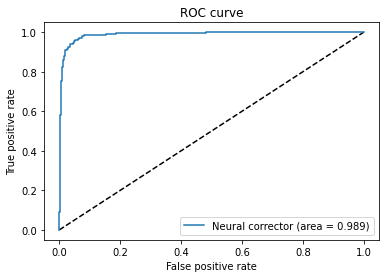

In [28]:
testModel(sm)

In [29]:
sm.save()

Saved model to disk: model_10_06_2020_18_54_37.h5
Saved tokenizer to disk: tokenizer_10_06_2020_18_54_37.pickle


36864 36864
(36863, 200) (36863, 1) (1, 200) (1, 1)
36864 36864
(36863, 200) (36863, 1) (1, 200) (1, 1)
Epoch 1/2
576/576 [==============================] - 25s 43ms/step - loss: 0.2725 - accuracy: 0.8900 - val_loss: 0.1168 - val_accuracy: 0.9587
Epoch 2/2
576/576 [==============================] - 25s 43ms/step - loss: 0.1034 - accuracy: 0.9646 - val_loss: 0.0464 - val_accuracy: 0.9842


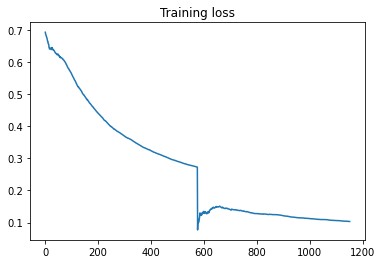

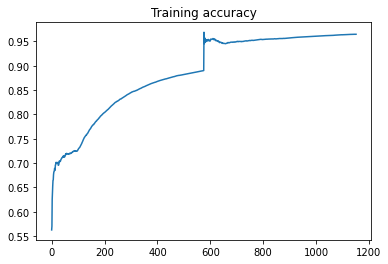

1152/1152 [==============================] - 6s 5ms/step - loss: 0.0464 - accuracy: 0.9842
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     26619
           1       0.96      0.98      0.97     10244

    accuracy                           0.98     36863
   macro avg       0.98      0.98      0.98     36863
weighted avg       0.98      0.98      0.98     36863

Area under the curve Neural corrector 0.9980259239454563


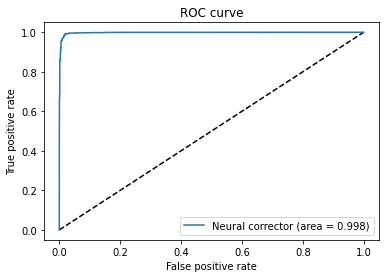

In [93]:
sm2 = trainModel(SimpleModel())

4608 4608
(4607, 200) (4607, 1) (1, 200) (1, 1)
144/144 [==============================] - 1s 6ms/step - loss: 0.0537 - accuracy: 0.9798
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3333
           1       0.95      0.98      0.96      1274

    accuracy                           0.98      4607
   macro avg       0.97      0.98      0.97      4607
weighted avg       0.98      0.98      0.98      4607

Area under the curve Neural corrector 0.9980259239454563


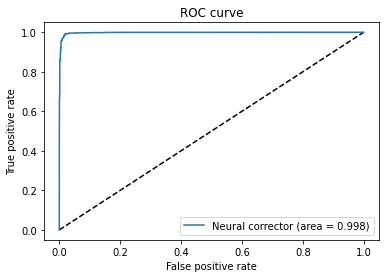

In [94]:
validateModel(sm2)

4608 4608
(4607, 200) (4607, 1) (1, 200) (1, 1)
144/144 [==============================] - 1s 5ms/step - loss: 0.0523 - accuracy: 0.9822
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3302
           1       0.96      0.97      0.97      1305

    accuracy                           0.98      4607
   macro avg       0.98      0.98      0.98      4607
weighted avg       0.98      0.98      0.98      4607

Area under the curve Neural corrector 0.9980259239454563


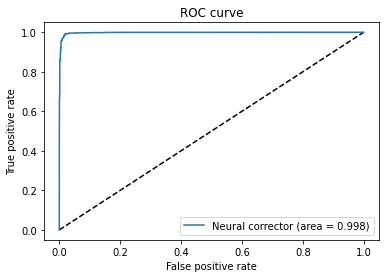

In [95]:
testModel(sm2)

In [97]:
sm2.save()

Saved model to disk: model_10_06_2020_21_30_17.h5
Saved tokenizer to disk: tokenizer_10_06_2020_21_30_17.pickle
